In [1]:
import numpy as np
import pandas as pd
import wget
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from obspy import read_events
from obspy.imaging.beachball import beach

%matplotlib inline

In [9]:
def read_nodal_plane(event):
    plane = event.preferred_focal_mechanism().nodal_planes.nodal_plane_1
    
    return plane.strike, plane.dip, plane.rake

def read_epi(event):
    origin = event.preferred_origin()
    
    return origin.longitude, origin.latitude

def plot_basemap(west, east, south, north):
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines(color='w')
    ax.set_extent([west, east, south, north])
    ax.set_xticks(np.arange(west, east+1, 10))
    ax.set_yticks(np.arange(south, north+1, 10))
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    
    return ax

def gcmt_url(year, month):
    #url for focal mechanism data since 2015
    pre = 'https://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/'

    return pre + str(year) + '/' + month + str(year)[-2:] + '.ndk'

def download_gcmt(url, out='cat.ndk'):
    try:
        return wget.download(url, out=out)
    except:
        print(url[-9:-4]+' data not available')
        
def download_plate_boundary(file='PB2002_boundaries.dig.txt'):
    
    return wget.download('http://peterbird.name/oldFTP/PB2002/PB2002_boundaries.dig.txt',
                         out=file)

def read_plate_boundaries(bfile):
    plate_boundaries = pd.DataFrame(columns=['ID','Boundary', 'Reference', 'Longitudes', 'Latitudes'])

    with open(bfile, 'r') as b_in:
        i = 0
        for line in b_in:
            l = line.split()
            if l[0][0].isalpha():
                i += 1
                boundary = l[0]
                reference = ' '.join(l[1:])
                b_long = []
                b_lat = []
            elif l[0].startswith('-') or l[0].startswith('+'):
                long = float(l[0].split(sep=',')[0])
                lat = float(l[0].split(sep=',')[1])
                b_long.append(long)
                b_lat.append(lat)
            elif l[0].startswith('*'):
                b = {'ID': int(i),
                     'Boundary': boundary,
                     'Reference': reference,
                     'Longitudes': [b_long],
                     'Latitudes': [b_lat]
                    }
                plate_boundaries = plate_boundaries.append(pd.DataFrame(data=b), sort=False)
    plate_boundaries.set_index('ID', inplace = True)
    
    return plate_boundaries

def plot_boundary(ax, boundary):
    longitudes = []
    latitudes = []
    for long, lat in zip(boundary.Longitudes, boundary.Latitudes):
        if long>west and long<east and lat>south and lat<north:
            longitudes.append(long)
            latitudes.append(lat)
    ax.plot(longitudes, latitudes, '-r')

In [3]:
#GCMT data filenames use three letters to depict months
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

In [4]:
#download data of all months in 2019 and put them in one ndk file
year = '2019'
ndk = 'cat.ndk'
!rm -f ndk
for month in months:
    filename = year + month + '.ndk'
    !rm -f {filename}
    filename = download_gcmt(gcmt_url(year, month), out=filename)
    !cat {filename} >> {ndk}
    !rm -f {filename}

nov19 data not available
cat: None: No such file or directory
dec19 data not available
cat: None: No such file or directory


In [5]:
#read the seismic events from the downloaded data file
cat = read_events(ndk)

In [6]:
#download the plate boundary data from Peter Bird 2002
bfile = download_plate_boundary()
boundaries = read_plate_boundaries(bfile)

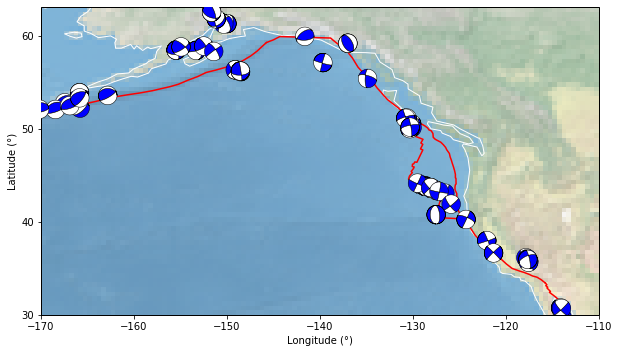

In [11]:
#define the boundary of the map
west, east, south, north = -170, -110, 30, 60

#plot the base map
ax = plot_basemap(west, east, south, north)

#plot the plate boundary in the map area
for _, b in boundaries.iterrows():
    plot_boundary(ax, b)

#plot the downloaded seismic events
for event in cat:
    epicentre = read_epi(event)
    plane = read_nodal_plane(event)

    b = beach(plane, xy=epicentre, width=2, linewidth=.5)
    ax.add_collection(b)